<a href="https://colab.research.google.com/github/Yoon0527/AIFFEL_Going_Deeper/blob/main/%5BGD_10%5D_Semantic_Segmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# [GD_10] 도로 영역을 찾자! - 세그멘테이션 모델 만들기
U-Net을 이용해 이미지가 입력되면 도로의 영역을 Segmentation 하는 모델을 만들어보자. 

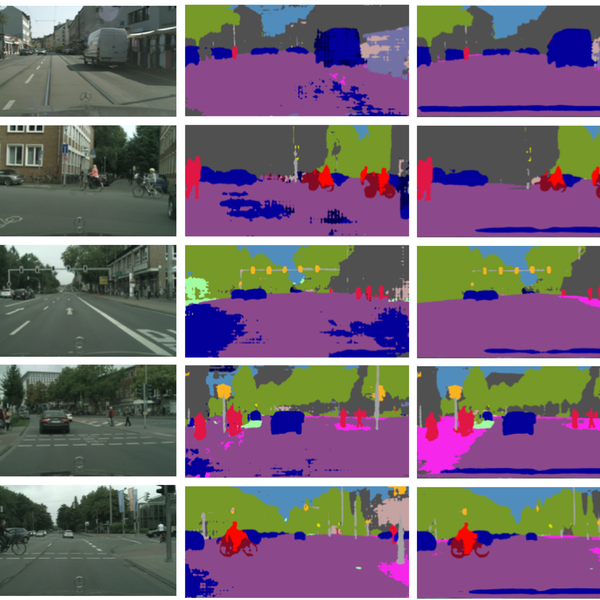

## Semantic Segmentation dataset


### 이미지, 데이터 가져오기
먼저 semantic segmentation으로 도로의 영역을 분리하기 위해서 도로의 영역을 라벨로 가진 데이터셋을 가지고 학습할 수 있도록 파싱해야 한다.
> 아래 링크로 object detection으로 사용했던 KITTI 데이터셋의 segmentation 데이터를 다운로드 한다.
>
> 데이터 출처: http://www.cvlibs.net/datasets/kitti/eval_semantics.php

> **Q1. 시맨틱 세그멘테이션의 이미지 라벨의 각 pixel 값은 의미를 갖습니다. 그렇다면 오늘 우리가 시맨틱 세그멘테이션으로 찾아내야 할 도로의 label은 어떤 값일까요?**
>
> A. 7입니다.

### data loader 만들기
로더는 입력값 (224, 224), 출력값 (224, 224) 크기를 갖는 모델을 학습시킬 수 있도록 데이터셋을 파싱해야 한다.

이 때 데이터 로더에 albumentations를 사용해 augmentation을 적용해 보자. 
또한 학습셋의 일정량을 검증 데이터셋(validation dataset)으로 활용할 수 있도록 해야한다.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
#필요한 라이브러리를 로드합니다. 
import os
import math
import numpy as np
import tensorflow as tf

from PIL import Image
import matplotlib.pyplot as plt
from skimage.io import imread
from skimage.transform import resize
from glob import glob

from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import *

print('슝=3')

슝=3


In [ ]:
from albumentations import  HorizontalFlip, RandomSizedCrop, Compose, OneOf, Resize

def build_augmentation(is_train=True):
  if is_train:    # 훈련용 데이터일 경우
    return Compose([
                    HorizontalFlip(p=0.5),    # 50%의 확률로 좌우대칭
                    RandomSizedCrop(         # 50%의 확률로 RandomSizedCrop
                        min_max_height=(300, 370),
                        w2h_ratio=370/1242,
                        height=224,
                        width=224,
                        p=0.5
                        ),
                    Resize(              # 입력이미지를 224X224로 resize
                        width=224,
                        height=224
                        )
                    ])
  return Compose([      # 테스트용 데이터일 경우에는 224X224로 resize만 수행합니다. 
                Resize(
                    width=224,
                    height=224
                    )
                ])

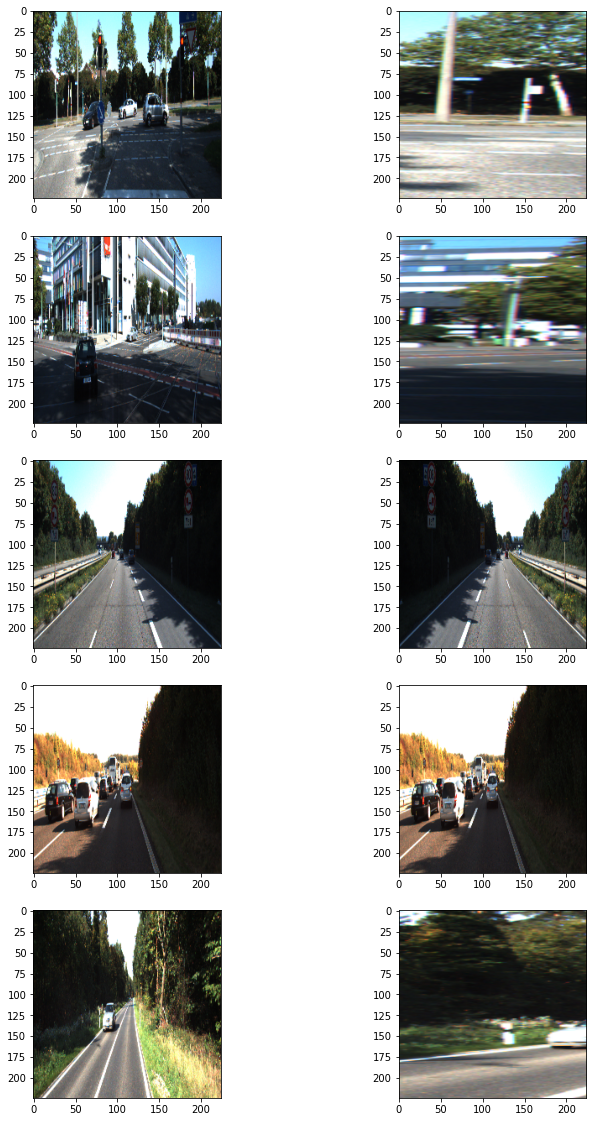

In [ ]:
dir_path = '/content/drive/MyDrive/aiffel/gd-10/training'

augmentation_train = build_augmentation()
augmentation_test = build_augmentation(is_train=False)
input_images = glob(os.path.join(dir_path, "image_2", "*.png"))

# 훈련 데이터셋에서 5개만 가져와 augmentation을 적용해 봅시다.  
plt.figure(figsize=(12, 20))
for i in range(5):
    image = imread(input_images[i]) 
    image_data = {"image":image}
    resized = augmentation_test(**image_data)
    processed = augmentation_train(**image_data)
    plt.subplot(5, 2, 2*i+1)
    plt.imshow(resized["image"])  # 왼쪽이 원본이미지
    plt.subplot(5, 2, 2*i+2)
    plt.imshow(processed["image"])  # 오른쪽이 augment된 이미지
  
plt.show()

In [ ]:
# 데이터셋 구성
# tf.keras.utils.Sequence를 상속받은 generator 형태로 구성
class KittiGenerator(tf.keras.utils.Sequence):
  '''
  KittiGenerator는 tf.keras.utils.Sequence를 상속받습니다.
  우리가 KittiDataset을 원하는 방식으로 preprocess하기 위해서 Sequnce를 커스텀해 사용합니다.
  '''
  def __init__(self, 
               dir_path,
               batch_size=16,
               img_size=(224, 224, 3),
               output_size=(224, 224),
               is_train=True,
               augmentation=None):
    '''
    dir_path: dataset의 directory path입니다.
    batch_size: batch_size입니다.
    img_size: preprocess에 사용할 입력이미지의 크기입니다.
    output_size: ground_truth를 만들어주기 위한 크기입니다.
    is_train: 이 Generator가 학습용인지 테스트용인지 구분합니다.
    augmentation: 적용하길 원하는 augmentation 함수를 인자로 받습니다.
    '''
    self.dir_path = dir_path
    self.batch_size = batch_size
    self.is_train = is_train
    self.dir_path = dir_path
    self.augmentation = augmentation
    self.img_size = img_size
    self.output_size = output_size

    # load_dataset()을 통해서 kitti dataset의 directory path에서 라벨과 이미지를 확인합니다.
    self.data = self.load_dataset()

  def load_dataset(self):
    # kitti dataset에서 필요한 정보(이미지 경로 및 라벨)를 directory에서 확인하고 로드하는 함수입니다.
    # 이때 is_train에 따라 test set을 분리해서 load하도록 해야합니다.
    input_images = glob(os.path.join(self.dir_path, "image_2", "*.png"))
    label_images = glob(os.path.join(self.dir_path, "semantic", "*.png"))
    input_images.sort()
    label_images.sort()
    assert len(input_images) == len(label_images)
    data = [ _ for _ in zip(input_images, label_images)]

    if self.is_train:
      return data[:-30]
    return data[-30:]
    
  def __len__(self):
    # Generator의 length로서 전체 dataset을 batch_size로 나누고 소숫점 첫째자리에서 올림한 값을 반환합니다.
    return math.ceil(len(self.data) / self.batch_size)

  def __getitem__(self, index):
    # 입력과 출력을 만듭니다.
    # 입력은 resize및 augmentation이 적용된 input image이고 
    # 출력은 semantic label입니다.
    batch_data = self.data[
                           index*self.batch_size:
                           (index + 1)*self.batch_size
                           ]
    inputs = np.zeros([self.batch_size, *self.img_size])
    outputs = np.zeros([self.batch_size, *self.output_size])
        
    for i, data in enumerate(batch_data):
      input_img_path, output_path = data
      _input = imread(input_img_path)
      _output = imread(output_path)
      _output = (_output==7).astype(np.uint8)*1
      data = {
          "image": _input,
          "mask": _output,
          }
      augmented = self.augmentation(**data)
      inputs[i] = augmented["image"]/255
      outputs[i] = augmented["mask"]
      return inputs, outputs

  def on_epoch_end(self):
    # 한 epoch가 끝나면 실행되는 함수입니다. 학습중인 경우에 순서를 random shuffle하도록 적용한 것을 볼 수 있습니다.
    self.indexes = np.arange(len(self.data))
    if self.is_train == True :
      np.random.shuffle(self.indexes)
      return self.indexes

In [ ]:
augmentation = build_augmentation()
test_preproc = build_augmentation(is_train=False)
        
train_generator = KittiGenerator(
    dir_path, 
    augmentation=augmentation,
)

test_generator = KittiGenerator(
    dir_path, 
    augmentation=test_preproc,
    is_train=False
)

## Semantic Segmentation model
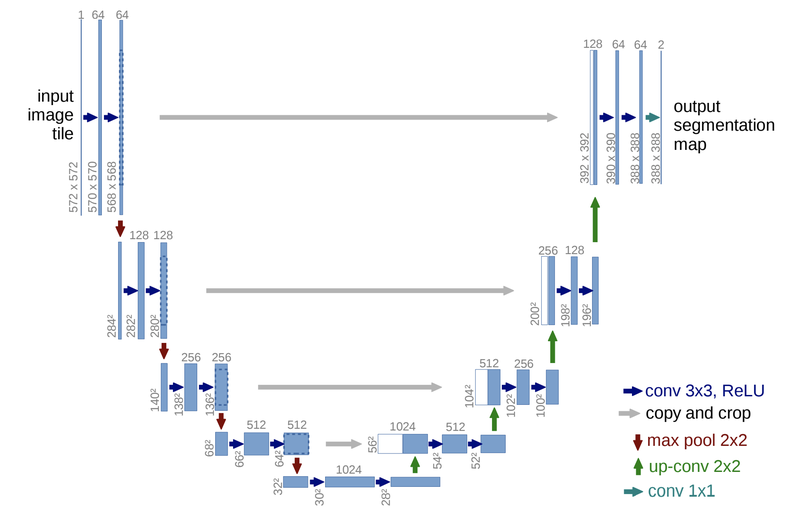

### 모델 구조 만들기
segmentation 모델 중 구조상 비교적 구현이 단순한 U-Net을 구현해보자

입력 이미지의 크기는 위에서 만든 데이터셋에 맞춰서 만든다.

In [ ]:
def build_model(input_shape=(224, 224, 3)):
  inputs = Input(input_shape)
	
  #Contracting Path
  conv1 = Conv2D(64, 3, activation='relu', padding='same',kernel_initializer='he_normal')(inputs)
  conv1 = Conv2D(64, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv1)
  pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
  conv2 = Conv2D(128, 3, activation='relu', padding='same',kernel_initializer='he_normal')(pool1)
  conv2 = Conv2D(128, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv2)
  pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
  conv3 = Conv2D(256, 3, activation='relu', padding='same',kernel_initializer='he_normal')(pool2)
  conv3 = Conv2D(256, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv3)
  pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
  conv4 = Conv2D(512, 3, activation='relu', padding='same',kernel_initializer='he_normal')(pool3)
  conv4 = Conv2D(512, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv4)
  drop4 = Dropout(0.5)(conv4)
  pool4 = MaxPooling2D(pool_size=(2, 2))(drop4)
  
  conv5 = Conv2D(1024, 3, activation='relu', padding='same',kernel_initializer='he_normal')(pool4)  
  conv5 = Conv2D(1024, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv5)
  
  #Expanding Path
  drop5 = Dropout(0.5)(conv5)
  up6 = Conv2DTranspose(512, 2, activation='relu', strides=(2,2), kernel_initializer='he_normal')(drop5)
  merge6 = concatenate([drop4,up6], axis = 3)
  conv6 = Conv2D(512, 3, activation='relu', padding='same',kernel_initializer='he_normal')(merge6)
  conv6 = Conv2D(512, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv6)
  up7 = Conv2DTranspose(256, 2, activation='relu', strides=(2,2), kernel_initializer='he_normal')(conv6)
  merge7 = concatenate([conv3,up7], axis = 3)
  conv7 = Conv2D(256, 3, activation='relu', padding='same',kernel_initializer='he_normal')(merge7)
  conv7 = Conv2D(256, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv7)
  up8 = Conv2DTranspose(128, 2, activation='relu', strides=(2,2), kernel_initializer='he_normal')(conv7)
  merge8 = concatenate([conv2,up8], axis = 3)
  conv8 = Conv2D(128, 3, activation='relu', padding='same',kernel_initializer='he_normal')(merge8)
  conv8 = Conv2D(128, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv8)
  up9 = Conv2DTranspose(64, 2, activation='relu', strides=(2,2), kernel_initializer='he_normal')(conv8)
  merge9 = concatenate([conv1,up9], axis = 3)
  conv9 = Conv2D(64, 3, activation='relu', padding='same',kernel_initializer='he_normal')(merge9)
  conv9 = Conv2D(64, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv9)  
  conv9 = Conv2D(2, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv9)     
  conv10 = Conv2D(1, 1, activation='sigmoid')(conv9)

  model = Model(inputs = inputs, outputs = conv10)
  return model

### 모델 학습하기

In [ ]:
model_path = '/content/drive/MyDrive/aiffel/gd-10/training/seg_model_unet.h5'

model = build_model()
model.compile(optimizer = Adam(1e-4), loss = 'binary_crossentropy')
model.fit(
     train_generator,
     validation_data=test_generator,
     steps_per_epoch=len(train_generator),
     epochs=100,
 )

model.save(model_path)  #학습한 모델을 저장해 주세요.

Epoch 1/100
11/11 [==============================] - 19s 453ms/step - loss: 0.6900 - val_loss: 0.6798
Epoch 2/100
11/11 [==============================] - 4s 322ms/step - loss: 0.6587 - val_loss: 0.5685
Epoch 3/100
11/11 [==============================] - 4s 323ms/step - loss: 0.1694 - val_loss: 0.0352
Epoch 4/100
11/11 [==============================] - 4s 322ms/step - loss: 0.0272 - val_loss: 0.0353
Epoch 5/100
11/11 [==============================] - 4s 323ms/step - loss: 0.0303 - val_loss: 0.0360
Epoch 6/100
11/11 [==============================] - 4s 323ms/step - loss: 0.0373 - val_loss: 0.0324
Epoch 7/100
11/11 [==============================] - 4s 322ms/step - loss: 0.0360 - val_loss: 0.0337
Epoch 8/100
11/11 [==============================] - 4s 322ms/step - loss: 0.0336 - val_loss: 0.0362
Epoch 9/100
11/11 [==============================] - 4s 323ms/step - loss: 0.0280 - val_loss: 0.0430
Epoch 10/100
11/11 [==============================] - 4s 323ms/step - loss: 0.0397 - val_l

## Semantic Segmentation 모델 시각화


In [ ]:
# 미리 준비한 모델을 불러오려면 아래 주석을 해제하세요
# model_path = dir_path + '/seg_model_unet.h5' 

model = tf.keras.models.load_model(model_path)

In [ ]:
def get_output(model, preproc, image_path, output_path):
     origin_img = imread(image_path)
     data = {"image":origin_img}
     processed = preproc(**data)
     output = model(np.expand_dims(processed["image"]/255,axis=0))
     output = (output[0].numpy()>0.5).astype(np.uint8).squeeze(-1)*255  #0.5라는 threshold를 변경하면 도로인식 결과범위가 달라집니다.
     output = Image.fromarray(output)
     background = Image.fromarray(origin_img).convert('RGBA')
     output = output.resize((origin_img.shape[1], origin_img.shape[0])).convert('RGBA')
     output = Image.blend(background, output, alpha=0.5)
     output.show()
     return output 

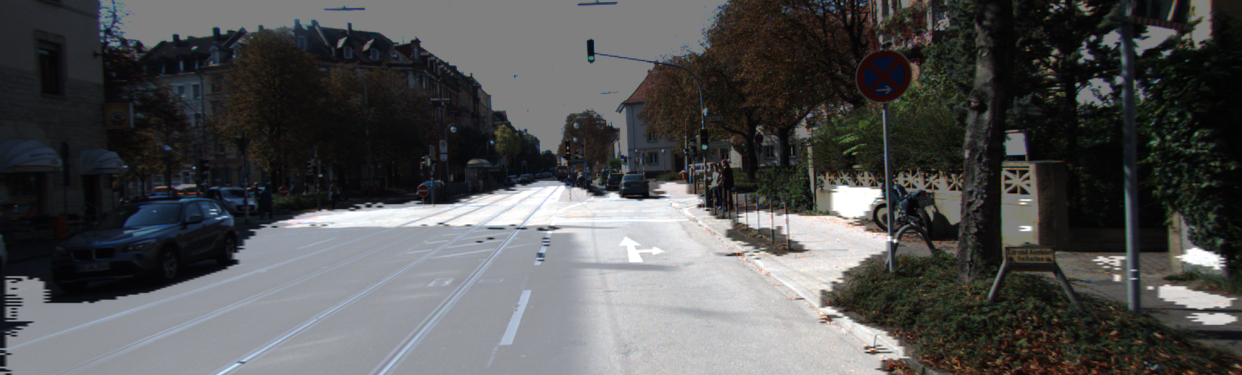

In [ ]:
# 완성한 뒤에는 시각화한 결과를 눈으로 확인해봅시다!
i = 1    # i값을 바꾸면 테스트용 파일이 달라집니다. 
get_output(
     model, 
     test_preproc,
     image_path=dir_path + f'/image_2/00{str(i).zfill(4)}_10.png',
     output_path=dir_path + f'./result_{str(i).zfill(3)}.png'
 )

In [ ]:
def calculate_iou_score(target, prediction):
    intersection = np.logical_and(target, prediction)
    union = np.logical_or(target, prediction)
    iou_score = float(np.sum(intersection)) / float(np.sum(union))
    print('IoU : %f' % iou_score )
    return iou_score

In [ ]:
def get_output(model, preproc, image_path, output_path, label_path):
    origin_img = imread(image_path)
    data = {"image":origin_img}
    processed = preproc(**data)
    output = model(np.expand_dims(processed["image"]/255,axis=0))
    output = (output[0].numpy()>=0.5).astype(np.uint8).squeeze(-1)*255  #0.5라는 threshold를 변경하면 도로인식 결과범위가 달라집니다.
    prediction = output/255   # 도로로 판단한 영역
    
    output = Image.fromarray(output)
    background = Image.fromarray(origin_img).convert('RGBA')
    output = output.resize((origin_img.shape[1], origin_img.shape[0])).convert('RGBA')
    output = Image.blend(background, output, alpha=0.5)
    output.show()   # 도로로 판단한 영역을 시각화!
     
    if label_path:   
        label_img = imread(label_path)
        label_data = {"image":label_img}
        label_processed = preproc(**label_data)
        label_processed = label_processed["image"]
        target = (label_processed == 7).astype(np.uint8)*1   # 라벨에서 도로로 기재된 영역

        return output, prediction, target
    else:
        return output, prediction, _

In [ ]:
# 완성한 뒤에는 시각화한 결과를 눈으로 확인해봅시다!
i = 1    # i값을 바꾸면 테스트용 파일이 달라집니다. 
output, prediction, target = get_output(
     model, 
     test_preproc,
     image_path=dir_path + f'/image_2/00{str(i).zfill(4)}_10.png',
     output_path=dir_path + f'./result_{str(i).zfill(3)}.png',
     label_path=dir_path + f'/semantic/00{str(i).zfill(4)}_10.png'
 )

calculate_iou_score(target, prediction)

IoU : 0.845052


0.8450518116697963

## 프로젝트: 개선된 U-Net 모델 만들기
|평가 문항|상세 기준|
|-|-|
|1. U-Net을 통한 세그멘테이션 작업이 정상적으로 진행되었다.|KITTI 데이터셋 구성, U-Net 모델 훈련, 결과물 시각화의 한 사이클이 정상 수행되어 세그멘테이션 결과 이미지를 제출하였다.|
|2. U-Net++ 모델이 성공적으로 구현되었는가?|U-Net++ 모델을 스스로 구현하여 학습 진행 후 세그멘테이션 결과까지 정상 진행되었다.|
|3. U-Net과 U-Net++ 두 모델의 성능이 정량적/정성적으로 잘 비교되었는가?|U-Net++의 세그멘테이션 결과 사진과 IoU 계산치를 U-Net과 비교하여 우월함을 확인하였다.|

In [1]:
import os
import math
import numpy as np
import tensorflow as tf

from PIL import Image
import matplotlib.pyplot as plt
from skimage.io import imread
from skimage.transform import resize
from glob import glob

from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.backend import int_shape

In [2]:
from albumentations import  HorizontalFlip, RandomSizedCrop, Compose, OneOf, Resize

def build_augmentation(is_train=True):
  if is_train:    # 훈련용 데이터일 경우
    return Compose([
                    HorizontalFlip(p=0.5),    # 50%의 확률로 좌우대칭
                    RandomSizedCrop(         # 50%의 확률로 RandomSizedCrop
                        min_max_height=(300, 370),
                        w2h_ratio=370/1242,
                        height=224,
                        width=224,
                        p=0.5
                        ),
                    Resize(              # 입력이미지를 224X224로 resize
                        width=224,
                        height=224
                        )
                    ])
  return Compose([      # 테스트용 데이터일 경우에는 224X224로 resize만 수행합니다. 
                Resize(
                    width=224,
                    height=224
                    )
                ])

### KITTI 데이터셋 수집과 구축

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
import os

dir_path = '/content/drive/MyDrive/aiffel/gd-10/training'

augmentation = build_augmentation()
input_images = glob(os.path.join(dir_path, "image_2", "*.png"))

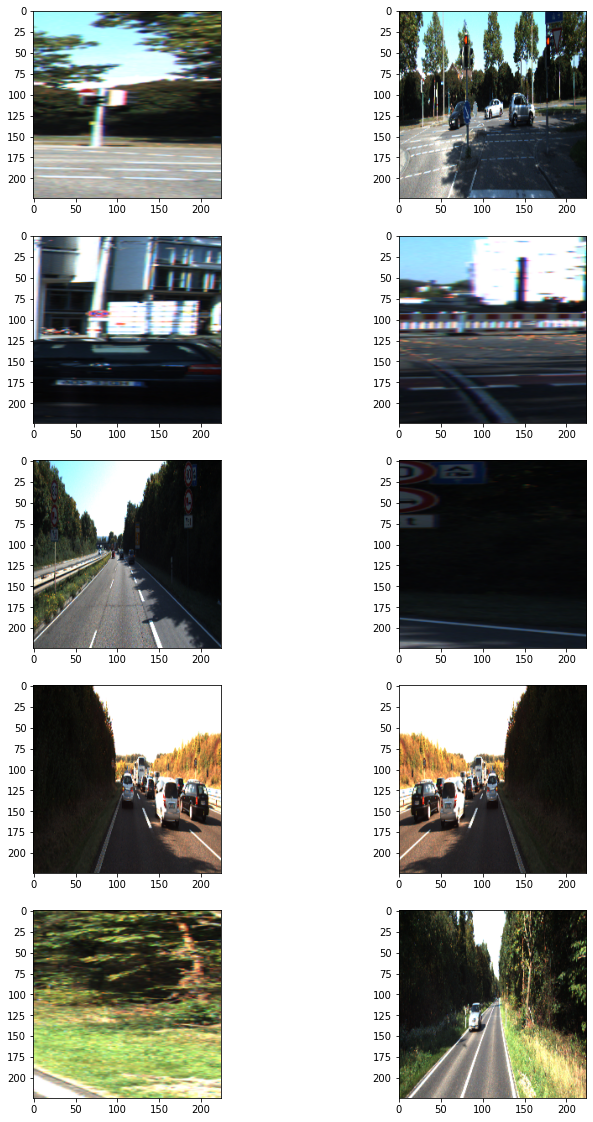

In [5]:
plt.figure(figsize=(12, 20))
for i in range(5):
    image = imread(input_images[i]) 
    image_data = {"image":image}
    resized = augmentation(**image_data, is_train=False)
    processed = augmentation(**image_data)
    plt.subplot(5, 2, 2*i+1)
    plt.imshow(resized["image"])  # 왼쪽이 원본이미지
    plt.subplot(5, 2, 2*i+2)
    plt.imshow(processed["image"])  # 오른쪽이 augment된 이미지
  
plt.show()

In [6]:
class KittiGenerator(tf.keras.utils.Sequence):
  '''
  KittiGenerator는 tf.keras.utils.Sequence를 상속받습니다.
  우리가 KittiDataset을 원하는 방식으로 preprocess하기 위해서 Sequnce를 커스텀해 사용합니다.
  '''
  def __init__(self, 
               dir_path,
               batch_size=4,
               img_size=(224, 224, 3),
               output_size=(224, 224),
               is_train=True,
               augmentation=None):
    '''
    dir_path: dataset의 directory path입니다.
    batch_size: batch_size입니다.
    img_size: preprocess에 사용할 입력이미지의 크기입니다.
    output_size: ground_truth를 만들어주기 위한 크기입니다.
    is_train: 이 Generator가 학습용인지 테스트용인지 구분합니다.
    augmentation: 적용하길 원하는 augmentation 함수를 인자로 받습니다.
    '''
    self.dir_path = dir_path
    self.batch_size = batch_size
    self.is_train = is_train
    self.dir_path = dir_path
    self.augmentation = augmentation
    self.img_size = img_size
    self.output_size = output_size

    # load_dataset()을 통해서 kitti dataset의 directory path에서 라벨과 이미지를 확인합니다.
    self.data = self.load_dataset()

  def load_dataset(self):
    # kitti dataset에서 필요한 정보(이미지 경로 및 라벨)를 directory에서 확인하고 로드하는 함수입니다.
    # 이때 is_train에 따라 test set을 분리해서 load하도록 해야합니다.
    input_images = glob(os.path.join(self.dir_path, "image_2", "*.png"))
    label_images = glob(os.path.join(self.dir_path, "semantic", "*.png"))
    input_images.sort()
    label_images.sort()
    assert len(input_images) == len(label_images)
    data = [ _ for _ in zip(input_images, label_images)]

    if self.is_train:
      return data[:-30]
    return data[-30:]
    
  def __len__(self):
    # Generator의 length로서 전체 dataset을 batch_size로 나누고 소숫점 첫째자리에서 올림한 값을 반환합니다.
    return math.ceil(len(self.data) / self.batch_size)

  def __getitem__(self, index):
    # 입력과 출력을 만듭니다.
    # 입력은 resize및 augmentation이 적용된 input image이고 
    # 출력은 semantic label입니다.
    batch_data = self.data[
                           index*self.batch_size:
                           (index + 1)*self.batch_size
                           ]
    inputs = np.zeros([self.batch_size, *self.img_size])
    outputs = np.zeros([self.batch_size, *self.output_size])
        
    for i, data in enumerate(batch_data):
      input_img_path, output_path = data
      _input = imread(input_img_path)
      _output = imread(output_path)
      _output = (_output==7).astype(np.uint8)*1
      data = {
          "image": _input,
          "mask": _output,
          }
      augmented = self.augmentation(**data)
      inputs[i] = augmented["image"]/255
      outputs[i] = augmented["mask"]
      return inputs, outputs

  def on_epoch_end(self):
    # 한 epoch가 끝나면 실행되는 함수입니다. 학습중인 경우에 순서를 random shuffle하도록 적용한 것을 볼 수 있습니다.
    self.indexes = np.arange(len(self.data))
    if self.is_train == True :
      np.random.shuffle(self.indexes)
      return self.indexes

In [7]:
def get_crop_shape(target, refer):
    # width, the 3rd dimension
    cw = target[2] - refer[2]
    assert (cw >= 0)
    if cw % 2 != 0:
        cw1, cw2 = int(cw/2), int(cw/2) + 1
    else:
        cw1, cw2 = int(cw/2), int(cw/2)
    # height, the 2nd dimension
    ch = target[1] - refer[1]
    assert (ch >= 0)
    if ch % 2 != 0:
        ch1, ch2 = int(ch/2), int(ch/2) + 1
    else:
        ch1, ch2 = int(ch/2), int(ch/2)

    return (ch1, ch2), (cw1, cw2)

In [8]:
augmentation = build_augmentation()
test_preproc = build_augmentation(is_train=False)
        
train_generator = KittiGenerator(
    dir_path, 
    augmentation=augmentation,
)

test_generator = KittiGenerator(
    dir_path, 
    augmentation=test_preproc,
    is_train=False
)

### U-Net++ 모델의 구현

In [9]:
def Unet_model(input_shape=(224, 224, 3), filters= [64, 128, 256, 512, 1024], kernel=3):
    inputs = Input(input_shape)
    x = Conv2D(filters[0], kernel, activation='relu', padding='valid',kernel_initializer='he_normal', name='b1_conv1')(inputs)
    b1 = Conv2D(filters[0], kernel, activation='relu', padding='valid',kernel_initializer='he_normal', name='b1_conv2')(x)
    
    x = MaxPooling2D(pool_size=(2,2), name='b2_pool')(b1)
    x = Conv2D(filters[1], kernel, activation='relu', padding='valid',kernel_initializer='he_normal', name='b2_conv1')(x)
    b2 = Conv2D(filters[1], kernel, activation='relu', padding='valid',kernel_initializer='he_normal', name='b2_conv2')(x)
    
    x = MaxPooling2D(pool_size=(2,2), name='b3_pool')(b2)
    x = Conv2D(filters[2], kernel, activation='relu', padding='valid',kernel_initializer='he_normal', name='b3_conv1')(x)
    b3 = Conv2D(filters[2], kernel, activation='relu', padding='valid',kernel_initializer='he_normal', name='b3_conv2')(x)
    
    x = MaxPooling2D(pool_size=(2,2), name='b4_pool')(b3)
    x = Conv2D(filters[3], kernel, activation='relu', padding='valid',kernel_initializer='he_normal', name='b4_conv1')(x)
    b4 = Conv2D(filters[3], kernel, activation='relu', padding='valid',kernel_initializer='he_normal', name='b4_conv2')(x)
    
    x = MaxPooling2D(pool_size=(2,2), name='b5_pool')(b4)
    x = Dropout(0.5)(x)
    x = Conv2D(filters[4], kernel, activation='relu', padding='same',kernel_initializer='he_normal', name='b5_conv1')(x)
    
    x = Conv2DTranspose(filters[3], (2, 2), strides=(2, 2), padding='valid', name='u1_convTran')(x)
    ch, cw = get_crop_shape(int_shape(b4), int_shape(x))
    r1 = Cropping2D(cropping=(ch, cw), name='u1_resize')(b4)
    x = concatenate([r1,x], axis = 3, name='u1_merge')
    x = Conv2D(filters[3], kernel, activation='relu', padding='valid',kernel_initializer='he_normal', name='u1_conv1')(x)
    x = Conv2D(filters[3], kernel, activation='relu', padding='valid',kernel_initializer='he_normal', name='u1_conv2')(x)
    
    x = Conv2DTranspose(filters[2], (2, 2), strides=(2, 2), padding='valid', name='u2_convTran')(x)
    ch, cw = get_crop_shape(int_shape(b3), int_shape(x))
    r2 = Cropping2D(cropping=(ch, cw), name='u2_resize')(b3)
    x = concatenate([r2,x], axis = 3, name='u2_merge')
    x = Conv2D(filters[2], kernel, activation='relu', padding='valid',kernel_initializer='he_normal', name='u2_conv1')(x)
    x = Conv2D(filters[2], kernel, activation='relu', padding='valid',kernel_initializer='he_normal', name='u2_conv2')(x)
    
    x = Conv2DTranspose(filters[1], (2, 2), strides=(2, 2), padding='valid', name='u3_convTran')(x)
    ch, cw = get_crop_shape(int_shape(b2), int_shape(x))
    r3 = Cropping2D(cropping=(ch, cw), name='u3_resize')(b2)
    x = concatenate([r3,x], axis = 3, name='u3_merge')
    x = Conv2D(filters[1], kernel, activation='relu', padding='valid',kernel_initializer='he_normal', name='u3_conv1')(x)
    x = Conv2D(filters[1], kernel, activation='relu', padding='valid',kernel_initializer='he_normal', name='u3_conv2')(x)
    
    x = Conv2DTranspose(filters[0], (2, 2), strides=(2, 2), padding='valid', name='u4_convTran')(x)
    ch, cw = get_crop_shape(int_shape(b1), int_shape(x))
    r4 = Cropping2D(cropping=(ch, cw ), name='u4_resize')(b1)
    x = concatenate([r4,x], axis = 3, name='u4_merge')
    x = Conv2D(filters[0], kernel, activation='relu', padding='valid',kernel_initializer='he_normal', name='u4_conv1')(x)
    x = Conv2D(filters[0], kernel, activation='relu', padding='valid',kernel_initializer='he_normal', name='u4_conv2')(x)
    x = Conv2D(2, kernel, activation='relu', padding='same',kernel_initializer='he_normal', name='u4_conv3')(x)
    x = Conv2D(1, 1, activation='sigmoid')(x)
    output = tf.image.resize(x, (inputs.shape[1], inputs.shape[2]), name='output')
    
    model = Model(inputs = inputs, outputs = output)
    return model

In [10]:
u_model = Unet_model()
u_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 b1_conv1 (Conv2D)              (None, 222, 222, 64  1792        ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 b1_conv2 (Conv2D)              (None, 220, 220, 64  36928       ['b1_conv1[0][0]']               
                                )                                                             

In [11]:
u_model.compile(optimizer = Adam(lr = 1e-4), loss = 'binary_crossentropy')
history = u_model.fit_generator(
     generator=train_generator,
     validation_data=test_generator,
     steps_per_epoch=len(train_generator),
     epochs=100,
 )

model_path = dir_path + '/seg_model_unet.h5'
u_model.save(model_path)  #학습한 모델을 저장해 주세요.

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  


Epoch 1/100
43/43 [==============================] - 52s 881ms/step - loss: 0.6936 - val_loss: 0.6909
Epoch 2/100
43/43 [==============================] - 5s 103ms/step - loss: 0.6901 - val_loss: 0.6892
Epoch 3/100
43/43 [==============================] - 4s 103ms/step - loss: 0.6882 - val_loss: 0.6871
Epoch 4/100
43/43 [==============================] - 4s 103ms/step - loss: 0.6862 - val_loss: 0.6852
Epoch 5/100
43/43 [==============================] - 4s 104ms/step - loss: 0.6843 - val_loss: 0.6835
Epoch 6/100
43/43 [==============================] - 4s 104ms/step - loss: 0.6825 - val_loss: 0.6815
Epoch 7/100
43/43 [==============================] - 4s 104ms/step - loss: 0.6808 - val_loss: 0.6797
Epoch 8/100
43/43 [==============================] - 4s 104ms/step - loss: 0.6788 - val_loss: 0.6779
Epoch 9/100
43/43 [==============================] - 4s 104ms/step - loss: 0.6769 - val_loss: 0.6761
Epoch 10/100
43/43 [==============================] - 5s 104ms/step - loss: 0.6750 - val_l

In [12]:
def Upp_model(input_shape=(224, 224, 3), filters= [0, 64, 128, 256, 512], kernel=3):
    inputs = Input(input_shape)
#     x0_0 = Conv2D(filters[0], kernel, activation='relu', padding='valid',kernel_initializer='he_normal', name='b1_conv1')(inputs)
#     x0_0 = Conv2D(filters[0], kernel, activation='relu', padding='valid',kernel_initializer='he_normal', name='b1_conv2')(x0_0)
    
    x1_0 = MaxPooling2D(pool_size=(2,2), name='x1_0_pool')(inputs)
    x1_0 = Conv2D(filters[1], kernel, activation='relu', padding='valid',kernel_initializer='he_normal', name='x1_0_conv1')(inputs)
    x1_0 = BatchNormalization()(x1_0)
    x1_0 = Conv2D(filters[1], kernel, activation='relu', padding='valid',kernel_initializer='he_normal', name='x1_0_conv2')(x1_0)
    x1_0 = BatchNormalization()(x1_0)
    
    x2_0 = MaxPooling2D(pool_size=(2,2), name='x2_0_pool')(x1_0)
    x2_0 = Conv2D(filters[2], kernel, activation='relu', padding='valid',kernel_initializer='he_normal', name='x2_0_conv1')(x2_0)
    x2_0 = BatchNormalization()(x2_0)
    x2_0 = Conv2D(filters[2], kernel, activation='relu', padding='valid',kernel_initializer='he_normal', name='x2_0_conv2')(x2_0)
    x2_0 = BatchNormalization()(x2_0)
    
    x3_0 = MaxPooling2D(pool_size=(2,2), name='x3_0_pool')(x2_0)
    x3_0 = Conv2D(filters[3], kernel, activation='relu', padding='valid',kernel_initializer='he_normal', name='x3_0_conv1')(x3_0)
    x3_0 = BatchNormalization()(x3_0)
    x3_0 = Conv2D(filters[3], kernel, activation='relu', padding='valid',kernel_initializer='he_normal', name='x3_0_conv2')(x3_0)
    x3_0 = BatchNormalization()(x3_0)
    
    x4_0 = MaxPooling2D(pool_size=(2,2), name='x4_0_pool')(x3_0)
    x4_0 = Conv2D(filters[4], kernel, activation='relu', padding='valid',kernel_initializer='he_normal', name='x4_0_conv1')(x4_0)
    x4_0 = BatchNormalization()(x4_0)
    x4_0 = Conv2D(filters[4], kernel, activation='relu', padding='valid',kernel_initializer='he_normal', name='x4_0_conv2')(x4_0)
    x4_0 = BatchNormalization()(x4_0)
    
    u4_0 = Conv2DTranspose(filters[3], (2, 2), strides=(2, 2), padding='valid', name='u4_0_convTran')(x4_0)
    r3_0 = tf.image.resize(x3_0, (u4_0.shape[1], u4_0.shape[2]), name='x3_0_resize')
    x3_1 = concatenate([r3_0, u4_0], axis = 3, name='x3_1_merge')
    x3_1 = Conv2D(filters[3], kernel, activation='relu', padding='valid',kernel_initializer='he_normal', name='x3_1_conv1')(x3_1)
    x3_1 = Conv2D(filters[3], kernel, activation='relu', padding='valid',kernel_initializer='he_normal', name='x3_1_conv2')(x3_1)
    
    # 2-2로 감
    u3_0 = Conv2DTranspose(filters[2], (2, 2), strides=(2, 2), padding='valid', name='u3_0_convTran')(x3_0)
    r2_0 = tf.image.resize(x2_0, (u3_0.shape[1], u3_0.shape[2]), name='a_r2_0_resize')
    x2_1 = concatenate([r2_0,u3_0], axis = 3, name='x2_1_merge')
    x2_1 = Conv2D(filters[2], kernel, activation='relu', padding='valid',kernel_initializer='he_normal', name='x2_1_conv1')(x2_1)
    x2_1 = Conv2D(filters[2], kernel, activation='relu', padding='valid',kernel_initializer='he_normal', name='x2_1_conv2')(x2_1)
    
    # origin
    u3_1 = Conv2DTranspose(filters[2], (2, 2), strides=(2, 2), padding='valid', name='u3_1_convTran')(x3_1)
    r2_0 = tf.image.resize(x2_0, (u3_1.shape[1], u3_1.shape[2]), name='b_r2_0_resize')
    r2_1 = tf.image.resize(x2_1, (u3_1.shape[1], u3_1.shape[2]), name='b_r2_1_resize')
    x2_2 = concatenate([r2_0,r2_1, u3_1], axis = 3, name='x2_2_merge')
    x2_2 = Conv2D(filters[2], kernel, activation='relu', padding='valid',kernel_initializer='he_normal', name='x2_2_conv1')(x2_2)
    x2_2 = Conv2D(filters[2], kernel, activation='relu', padding='valid',kernel_initializer='he_normal', name='x2_2_conv2')(x2_2)
    
    # 1-3로 감
    u2_0 = Conv2DTranspose(filters[2], (2, 2), strides=(2, 2), padding='valid', name='u2_0_convTran')(x2_0)
    r1_0 = tf.image.resize(x1_0, (u2_0.shape[1], u2_0.shape[2]), name='a_r1_0_resize')
    x1_1 = concatenate([r1_0,u2_0], axis = 3, name='x1_1_merge')
    x1_1 = Conv2D(filters[1], kernel, activation='relu', padding='valid',kernel_initializer='he_normal', name='x1_1_conv1')(x1_1)
    x1_1 = Conv2D(filters[1], kernel, activation='relu', padding='valid',kernel_initializer='he_normal', name='x1_1_conv2')(x1_1)
    
    # 1-3로 감
    u2_1 = Conv2DTranspose(filters[2], (2, 2), strides=(2, 2), padding='valid', name='u2_1_convTran')(x2_1)
    r1_0 = tf.image.resize(x1_0, (u2_1.shape[1], u2_1.shape[2]), name='b_r1_0_resize')
    r1_1 = tf.image.resize(x1_1, (u2_1.shape[1], u2_1.shape[2]), name='b_r1_1_resize')
    x1_2 = concatenate([r1_0, r1_1, u2_1], axis = 3, name='x1_2_merge')
    x1_2 = Conv2D(filters[1], kernel, activation='relu', padding='valid',kernel_initializer='he_normal', name='x1_2_conv1')(x1_2)
    x1_2 = Conv2D(filters[1], kernel, activation='relu', padding='valid',kernel_initializer='he_normal', name='x1_2_conv2')(x1_2)
    
    # origin
    u2_2 = Conv2DTranspose(filters[2], (2, 2), strides=(2, 2), padding='valid', name='u2_2_convTran')(x2_2)
    r1_0 = tf.image.resize(x1_0, (u2_2.shape[1], u2_2.shape[2]), name='c_r1_0_resize')
    r1_1 = tf.image.resize(x1_1, (u2_2.shape[1], u2_2.shape[2]), name='c_r1_1_resize')
    r1_2 = tf.image.resize(x1_2, (u2_2.shape[1], u2_2.shape[2]), name='c_r1_2_resize')
    x1_3 = concatenate([r1_0, r1_1, r1_2, u2_2], axis = 3, name='x1_3_merge')
    x1_3 = Conv2D(filters[1], kernel, activation='relu', padding='valid',kernel_initializer='he_normal', name='x1_3_conv1')(x1_3)
    x1_3 = Conv2D(filters[1], kernel, activation='relu', padding='valid',kernel_initializer='he_normal', name='x1_3_conv2')(x1_3)
    x1_3 = Conv2D(2, kernel, activation='relu', padding='same',kernel_initializer='he_normal', name='x1_3_conv3')(x1_3)
    x1_3 = Conv2D(1, 1, activation='sigmoid')(x1_3)
    output = tf.image.resize(x1_3, (inputs.shape[1], inputs.shape[2]), name='output')
    model = Model(inputs = inputs, outputs = output)
    return model

In [13]:
upp_model = Upp_model()
upp_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 x1_0_conv1 (Conv2D)            (None, 222, 222, 64  1792        ['input_2[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 222, 222, 64  256        ['x1_0_conv1[0][0]']             
 alization)                     )                                                           

In [14]:
upp_model = Upp_model()
upp_model.compile(optimizer = Adam(lr = 1e-4), loss = 'binary_crossentropy')
upp_model.fit_generator(
     generator=train_generator,
     validation_data=test_generator,
     steps_per_epoch=len(train_generator),
     epochs=100,
 )

model_path = dir_path + '/seg_model_uppnet.h5'
upp_model.save(model_path)  #학습한 모델을 저장해 주세요.

Epoch 1/100


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  import sys


43/43 [==============================] - 19s 287ms/step - loss: 0.1738 - val_loss: 0.1471
Epoch 2/100
43/43 [==============================] - 11s 251ms/step - loss: 0.0871 - val_loss: 0.1350
Epoch 3/100
43/43 [==============================] - 11s 251ms/step - loss: 0.0874 - val_loss: 0.1341
Epoch 4/100
43/43 [==============================] - 11s 252ms/step - loss: 0.0810 - val_loss: 0.1389
Epoch 5/100
43/43 [==============================] - 11s 254ms/step - loss: 0.0746 - val_loss: 0.1330
Epoch 6/100
43/43 [==============================] - 11s 253ms/step - loss: 0.0760 - val_loss: 0.1077
Epoch 7/100
43/43 [==============================] - 11s 255ms/step - loss: 0.0696 - val_loss: 0.1185
Epoch 8/100
43/43 [==============================] - 11s 255ms/step - loss: 0.0600 - val_loss: 0.1052
Epoch 9/100
43/43 [==============================] - 11s 256ms/step - loss: 0.0615 - val_loss: 0.0963
Epoch 10/100
43/43 [==============================] - 11s 257ms/step - loss: 0.0700 - val_loss

In [15]:
def get_output(model, preproc, image_path, output_path):
     origin_img = imread(image_path)
     data = {"image":origin_img}
     processed = preproc(**data)
     output = model(np.expand_dims(processed["image"]/255,axis=0))
     output = (output[0].numpy()>0.5).astype(np.uint8).squeeze(-1)*255  #0.5라는 threshold를 변경하면 도로인식 결과범위가 달라집니다.
     output = Image.fromarray(output)
     background = Image.fromarray(origin_img).convert('RGBA')
     output = output.resize((origin_img.shape[1], origin_img.shape[0])).convert('RGBA')
     output = Image.blend(background, output, alpha=0.5)
     output.show()
     return output

In [16]:
def calculate_iou_score(target, prediction):
    intersection = np.logical_and(target, prediction)
    union = np.logical_or(target, prediction)
    iou_score = float(np.sum(intersection)) / float(np.sum(union))
    print('IoU : %f' % iou_score )
    return iou_score

In [17]:
def get_output(model, preproc, image_path, output_path, label_path):
    origin_img = imread(image_path)
    data = {"image":origin_img}
    processed = preproc(**data)
    output = model(np.expand_dims(processed["image"]/255,axis=0))
    output = (output[0].numpy()>=0.5).astype(np.uint8).squeeze(-1)*255  
    prediction = output/255   # 도로로 판단한 영역
    
    output = Image.fromarray(output)
    background = Image.fromarray(origin_img).convert('RGBA')
    output = output.resize((origin_img.shape[1], origin_img.shape[0])).convert('RGBA')
    output = Image.blend(background, output, alpha=0.5)
    output.show()  
     
    if label_path:   
        label_img = imread(label_path)
        label_data = {"image":label_img}
        label_processed = preproc(**label_data)
        label_processed = label_processed["image"]
        target = (label_processed == 7).astype(np.uint8)*1   # 라벨에서 도로로 기재된 영역

        return output, prediction, target
    else:
        return output, prediction, _

In [18]:
i = 0    # i값을 바꾸면 테스트용 파일이 달라집니다. 
output, prediction, target = get_output(
     u_model, 
     test_preproc,
     image_path=dir_path + f'/image_2/00{str(i).zfill(4)}_10.png',
     output_path=dir_path + f'/result_{str(i).zfill(3)}.png',
     label_path=dir_path + f'/semantic/00{str(i).zfill(4)}_10.png'
 )

calculate_iou_score(target, prediction)

IoU : 0.038443


0.03844309462915601

In [19]:
i = 1    # i값을 바꾸면 테스트용 파일이 달라집니다. 
output, prediction, target = get_output(
     upp_model, 
     test_preproc,
     image_path=dir_path + f'/image_2/00{str(i).zfill(4)}_10.png',
     output_path=dir_path + f'/result_{str(i).zfill(3)}.png',
     label_path=dir_path + f'/semantic/00{str(i).zfill(4)}_10.png'
 )

calculate_iou_score(target, prediction)

IoU : 0.912741


0.9127408993576017

https://github.com/PEBpung/Aiffel/blob/master/Project/Going%20Deeper/G8_Segmentation.ipynb

위 링크의 코드를 참고하여 본 결과 U-Net++에서 batchnormalization, dropout 등을 적용해야 기본 모델보다 나은 성능을 보인다는 것을 알 수 있었다. 다만 이미지가 출력이 안되는데 이유를 모르겠다...